In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
temps = np.random.normal(65,5,92)
HDD_p = np.maximum(0,65-temps)
CDD_p = np.maximum(0,temps-65)
df = pd.DataFrame(np.array([temps,HDD_p,CDD_p]).T,index = range(1,len(temps)+1),
                  columns = ['Avg Temp','HDD','CDD'])
df.loc['Total'] = pd.Series(df[['HDD','CDD']].sum())
round(df,2)

,Avg Temp,HDD,CDD
1,69.17,0.00,4.17
2,79.84,0.00,14.84
3,71.38,0.00,6.38
4,60.94,4.06,0.00
5,61.33,3.67,0.00
...,...,...,...
89,63.72,1.28,0.00
90,57.84,7.16,0.00
91,72.80,0.00,7.80
92,65.05,0.00,0.05


In [3]:
alpha = 5000
beta = 5000
Kc = 750
Kp = 550
C = 5e5
F = 1e6
DD = np.arange(200,1000,10)
call = np.minimum(alpha*np.maximum(DD-Kc,0),C)
put = np.minimum(alpha*np.maximum(Kp-DD,0),F)
collar = call - put

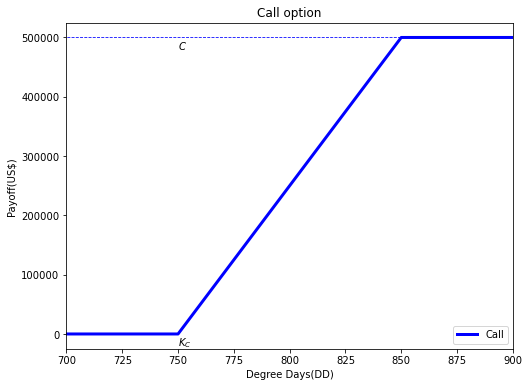

In [6]:
fig = plt.figure(figsize = (8,6))
plt.plot(DD,call,'b',linewidth = 3,label = 'Call')
plt.plot([200,1000],[C,C],'b--',linewidth = 0.8)
plt.text(750,C-.2e5,r'$C$')
plt.text(Kc,-.2e5,r'$K_C$')
plt.xlim([700,900])
plt.ylabel('Payoff(US$)')
plt.xlabel('Degree Days(DD)')
plt.title('Call option')
plt.legend()
plt.show()

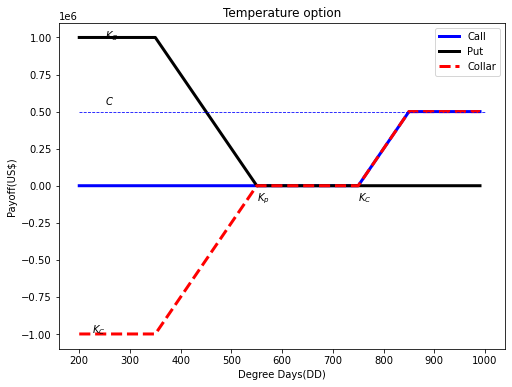

In [7]:
fig = plt.figure(figsize = (8,6))
plt.plot(DD,call,'b',linewidth = 3,label = 'Call')
plt.plot(DD,put,'k',linewidth = 3,label = 'Put')
plt.plot(DD,collar,'r--',linewidth = 3,label = 'Collar')
plt.plot([200,1000],[C,C],'b--',linewidth = 0.8)

plt.text(250,C+.5e5,r'$C$')
plt.text(250,F-.1e5,r'$K_C$')
plt.text(225,-F+.1e5,r'$K_C$')
plt.text(Kc,-.1e6,r'$K_C$')
plt.text(Kp,-.1e6,r'$K_p$')

plt.ylabel('Payoff(US$)')
plt.xlabel('Degree Days(DD)')
plt.title('Temperature option')
plt.legend()
plt.show()

In [8]:
import os
import datetime as dt

In [11]:
min_temp = pd.read_csv('max.csv')
max_temp = pd.read_csv('min.csv')

In [12]:
max_temp.head(3)

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66062,1859,1,1,24.4,NaN,Y
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y


In [15]:
max_temp[['Maximum temperature (Degree C)']].isnull().value_counts(),min_temp[['Minimum temperature (Degree C)']].isna().value_counts()

(Maximum temperature (Degree C)
 False                             58895
 True                                152
 Name: count, dtype: int64,
 Minimum temperature (Degree C)
 False                             58897
 True                                151
 Name: count, dtype: int64)

In [17]:
count = 0
for mx,mn in zip(np.where(max_temp[['Maximum temperature (Degree C)']].isnull())[0],
                 np.where(min_temp[['Minimum temperature (Degree C)']].isnull())[0]):
    if mx!=mn:
        count+=1
print('Number of Misaligned Nulls: ',count)

Number of Misaligned Nulls:  11


In [20]:
def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

In [21]:
max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date',inplace=True)
min_temp.set_index('Date',inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'},inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'},inplace=True)

In [22]:
temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on = ['Date'])
def avg_temp(row):
    return (row.Tmax+row.Tmin)/2
temps['T'] = temps.apply(avg_temp,axis = 1)
temps = temps.dropna()
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2020-08-26,19.6,6.8,13.20
2020-08-27,22.2,6.8,14.50
2020-08-28,19.7,10.4,15.05


In [23]:
temps.describe()

,Tmax,Tmin,T
count,58889.000000,58889.000000,58889.000000
mean,21.745061,13.809998,17.777530
std,4.671522,4.442761,4.296441
min,7.700000,2.100000,6.400000
25%,18.200000,10.100000,14.200000
50%,21.600000,14.000000,17.900000
75%,24.900000,17.500000,21.100000
max,45.800000,27.600000,33.750000


In [25]:
temps_season = temps.copy(deep = True)
temps_season['month'] = temps_season.index.month
mask = (temps_season['month']>=5)&(temps_season['month']<=10)
temps_season['winter'] = np.where(mask,1,0)
temps_season['summer'] = np.where(temps_season['winter']!=1,1,0)
temps_season

,Tmax,Tmin,T,month,winter,summer
Date,,,,,,
1859-01-01,24.4,14.5,19.45,1,0,1
1859-01-02,24.4,15.7,20.05,1,0,1
1859-01-03,24.2,15.3,19.75,1,0,1
1859-01-04,24.7,17.4,21.05,1,0,1
1859-01-05,24.6,16.9,20.75,1,0,1
...,...,...,...,...,...,...
2020-08-26,19.6,6.8,13.20,8,1,0
2020-08-27,22.2,6.8,14.50,8,1,0
2020-08-28,19.7,10.4,15.05,8,1,0


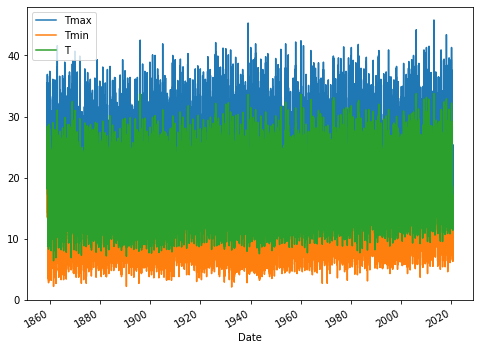

In [28]:
temps[:].plot(figsize=(8,6))
plt.show()

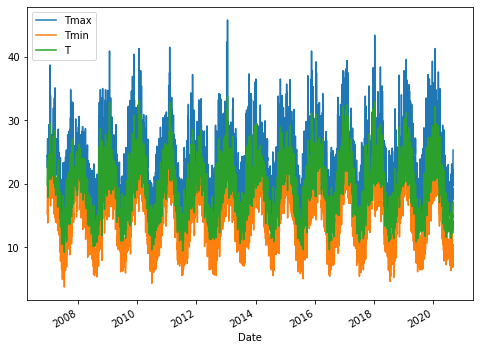

In [29]:
temps[-5000:].plot(figsize=(8,6))
plt.show()

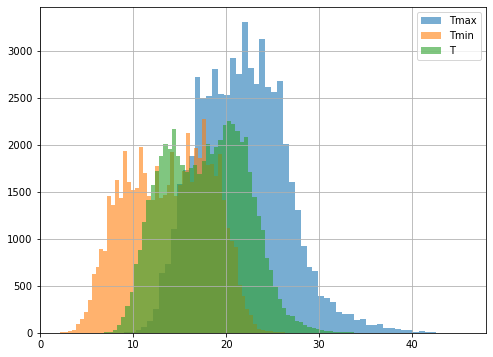

In [35]:
plt.figure(figsize=(8,6))
temps.Tmax.hist(bins=60,alpha=0.6,label='Tmax')
temps.Tmin.hist(bins=60,alpha=0.6,label='Tmin')
temps['T'].hist(bins=60,alpha=0.6,label='T')
plt.legend()
plt.show()

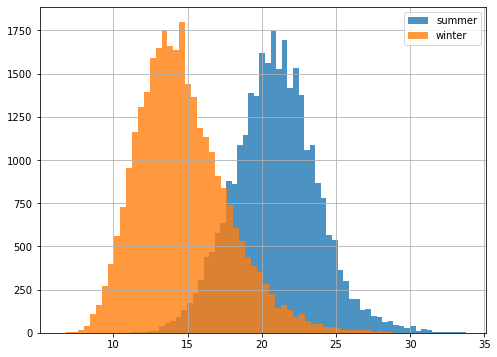

In [36]:
plt.figure(figsize=(8,6))
temps_season[temps_season['summer']==1]['T'].hist(bins=60,alpha=0.8,label='summer')
temps_season[temps_season['winter']==1]['T'].hist(bins=60,alpha=0.8,label='winter')
plt.legend()
plt.show()

In [37]:
date_list = temps.index.tolist()

In [58]:
mth_temps = pd.DataFrame(data = date_list, index = date_list).resample('MS')[0].agg([min,max])
mth_temps['month'] = mth_temps.index.month    

In [64]:
temps.loc['1859-01-01':'1859-01-31'].agg([min,max])

,Tmax,Tmin,T
min,20.6,14.5,18.1
max,36.9,19.9,28.4


In [61]:
def min_max_temps(row):
    stats = temps[(temps.index>=row['min'])&(temps.index<=row['max'])].agg([min,max])
    row['Tmax_max'] = stats.loc['max','Tmax']
    row['Tmax_min'] = stats.loc['min','Tmax']
    row['Tmin_max'] = stats.loc['max','Tmin']
    row['Tmin_min'] = stats.loc['min','Tmin']
    row['T_max'] = stats.loc['max','T']
    row['T_min'] = stats.loc['min','T']
    return row
mth_temps = mth_temps.apply(min_max_temps,axis=1)
mth_temps

,min,max,month,Tmax_max,Tmax_min,Tmin_max,Tmin_min,T_max,T_min
1859-01-01,1859-01-01,1859-01-31,1,36.9,20.6,19.9,14.5,28.40,18.10
1859-02-01,1859-02-01,1859-02-28,2,35.6,19.9,20.0,13.3,26.95,17.25
1859-03-01,1859-03-01,1859-03-31,3,30.4,18.8,18.9,13.3,23.55,17.10
1859-04-01,1859-04-01,1859-04-30,4,31.1,16.8,17.7,7.8,22.45,13.25
1859-05-01,1859-05-01,1859-05-31,5,28.6,13.9,16.7,4.6,22.65,9.25
...,...,...,...,...,...,...,...,...,...
2020-04-01,2020-04-01,2020-04-30,4,29.2,19.6,20.2,11.3,22.95,16.40
2020-05-01,2020-05-01,2020-05-31,5,28.5,15.6,17.2,7.8,22.10,12.55
2020-06-01,2020-06-01,2020-06-30,6,22.6,15.1,14.5,7.2,18.55,11.55
2020-07-01,2020-07-01,2020-07-31,7,23.0,15.0,13.6,7.1,17.05,12.50


In [74]:
grouped_mths = mth_temps.groupby(mth_temps.month)[['Tmax_max','Tmax_min','Tmin_max','Tmin_min','T_max','T_min']].agg(
    {'Tmax_max': ['max', 'min'], 'Tmax_min': ['max', 'min'], 'Tmin_max': ['max', 'min']
    , 'Tmin_min': ['max', 'min'], 'T_max': ['max', 'min'], 'T_min': ['max', 'min']})
grouped_mths

Tmax_max       Tmax_min       Tmin_max       Tmin_min        T_max   
           max   min      max   min      max   min      max   min    max   
month                                                                      
1         45.8  26.6     24.3  17.2     26.2  19.7     18.5  10.6  33.75  \
2         42.1  26.5     24.8  15.6     27.6  19.5     18.7   9.6  33.10   
3         39.8  25.3     22.6  16.2     25.4  18.3     16.7   9.3  31.75   
4         35.4  23.1     20.7  13.8     24.3  15.7     14.7   7.0  29.10   
5         30.0  19.3     18.6  11.3     20.8  12.9     10.4   4.4  24.55   
6         26.9  16.7     16.1   9.7     18.4   9.5      8.6   2.1  21.60   
7         26.5  16.6     16.2   7.7     18.1   8.7      7.6   2.2  20.90   
8         31.3  18.4     16.5   9.1     19.7  10.2      7.3   2.7  25.05   
9         34.6  21.1     18.4   9.5     23.0  11.7     10.0   4.9  26.90   
10        38.2  23.8     19.7  12.1     25.6  14.9     12.9   5.7  30.55   
11        41.8  24.2     22.7  12.6     24.8  17.0     15.1   7.7  32.25   
12        42.2  26.8     23.3  15.2     27.1  18.9     17.3   9.1  32.60   

              T_min         
         min    max    min  
month                       
1      22.75  21.95  15.05  
2      23.20  21.95  12.60  
3      22.15  20.65  13.10  
4      19.45  18.20  11.20  
5      16.20  14.95   9.20  
6      13.25  12.90   7.80  
7      12.35  12.50   6.40  
8      14.45  12.45   7.30  
9      17.25  15.25   7.85  
10     19.05  17.50   9.90  
11     20.40  18.35  12.45  
12     22.05  20.40  14.00

In [75]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg,ar_select_order,AutoRegResults

In [76]:
temps.sort_index(inplace=True)
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2020-08-26,19.6,6.8,13.20
2020-08-27,22.2,6.8,14.50
2020-08-28,19.7,10.4,15.05


<AxesSubplot:title={'center':'Rolling mean'}, xlabel='Date'>

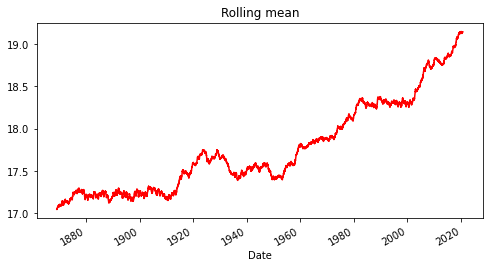

In [77]:
temps['T'].rolling(window = 365*10).mean().plot(figsize = (8,4), color ='red',title = 'Rolling mean')

<AxesSubplot:title={'center':'Rolling var'}, xlabel='Date'>

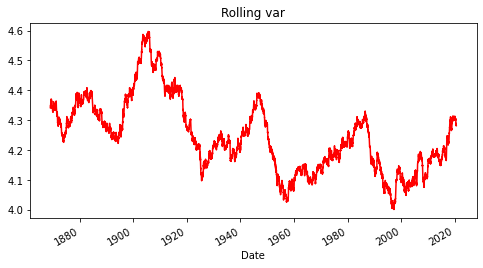

In [79]:
temps['T'].rolling(window = 365*10).std().plot(figsize = (8,4), color ='red',title = 'Rolling var')

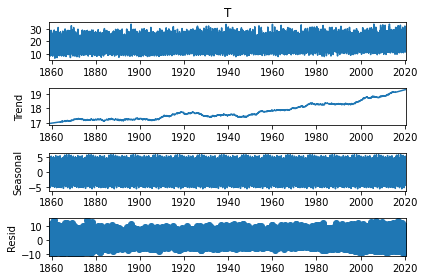

In [80]:
decompose_result = seasonal_decompose(temps['T'],model = 'additive',
                                      period = int(365*10),extrapolate_trend='freq')
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot()
plt.show()

(-15.0, 15.0)

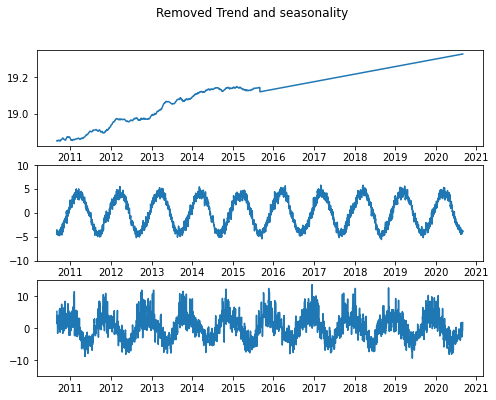

In [81]:
years_examine = 365*10
fig,axs = plt.subplots(3,figsize=(8,6))
fig.suptitle('Removed Trend and seasonality')
axs[0].plot(trend[-years_examine:])
axs[1].plot(seasonal[-years_examine:])
axs[1].set_ylim([-10,10])
axs[2].plot(residual[-years_examine:])
axs[2].set_ylim([-15,15])

In [82]:
dftest = adfuller(residual[-5000:],autolag = 'AIC')
print('1. ADF: ',dftest[0])
print('2. p-value: ',dftest[1])
print('3. Num of Lags: ',dftest[2])
print('4. Num of Observations used for ADF regression: ',dftest[3])
print('5. Critical values: ')
for key,val in dftest[4].items():
    print("\t",key,": ",val)


1. ADF:  -4.610916729066975
2. p-value:  0.0001233155305415107
3. Num of Lags:  18
4. Num of Observations used for ADF regression:  4981
5. Critical values: 
	 1% :  -3.4316635260404795
	 5% :  -2.8621204359855366
	 10% :  -2.567078966862675


<AxesSubplot:>

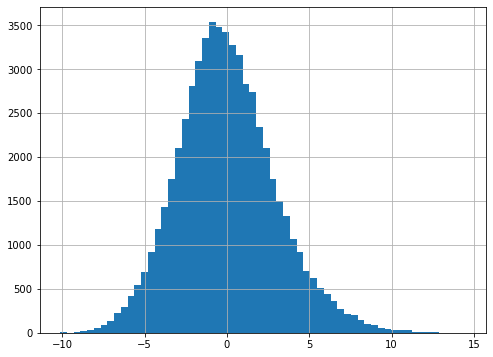

In [94]:
residual.hist(bins = 60,figsize=(8,6))

Skewness: 0.37
Kurtosis: 0.45


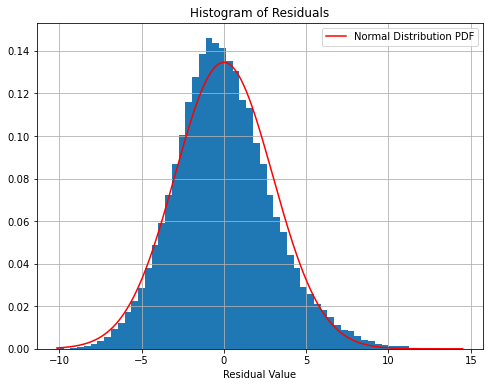

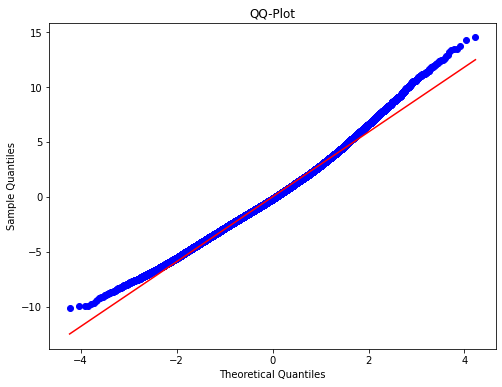

In [104]:
import scipy.stats as stats
import seaborn as sns
# Plot histogram of residuals
plt.figure(figsize=(8, 6))
residual.hist(bins = 60,figsize=(8,6),density=True)
plt.xlabel('Residual Value')
plt.title('Histogram of Residuals')

x = np.linspace(np.min(residual), np.max(residual), 1000)
pdf = stats.norm.pdf(x, loc=np.mean(residual), scale=np.std(residual))
plt.plot(x, pdf, color='red', label='Normal Distribution PDF')
plt.legend()

# Print skew and kurtosis of residuals
skewness = stats.skew(residual)
kurtosis = stats.kurtosis(residual)
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

# Create QQ-plot
plt.figure(figsize=(8, 6))
stats.probplot(residual, dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ-Plot')

plt.show()

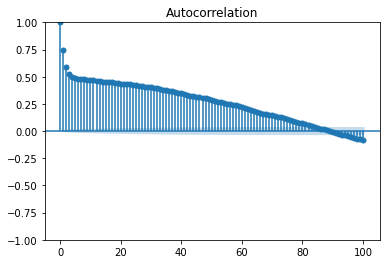

In [84]:
plot_acf(residual,lags = 100)
plt.show()

/home/ohj/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


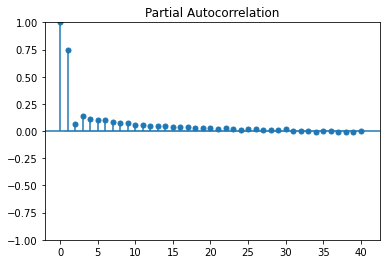

In [85]:
plot_pacf(residual,lags = 40)
plt.show()

In [86]:
residuals = residual.copy(deep = True)
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

/home/ohj/.local/lib/python3.10/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(
/home/ohj/.local/lib/python3.10/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(


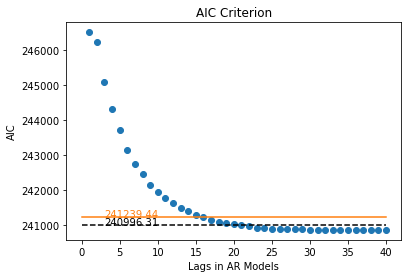

In [88]:
mod = ar_select_order(residuals,maxlag=40,ic='aic',old_names=True)
aic = []
for key,val in mod.aic.items():
    if key!=0:
        aic.append((key[-1],val))
aic.sort()
x,y = [x for x,y in aic],[y for x,y in aic]
plt.scatter(x,y)
plt.plot([0,40],[y[15],y[15]],'tab:orange')
plt.text(3,y[15]+0.002,'{0}'.format(round(y[15],3)),color='tab:orange')
plt.plot([0,40],[y[20],y[20]],'k--')
plt.text(3,y[20]-0.004,'{0}'.format(round(y[20],3)))
plt.title('AIC Criterion')
plt.xlabel('Lags in AR Models')
plt.ylabel('AIC')
plt.show()

In [90]:
model = AutoReg(residuals,lags = 15, old_names=True, trend = 'n')
model_fit = model.fit()
coef = model_fit.params
res = model_fit.resid
res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                58889
Model:                    AutoReg(15)   Log Likelihood             -120691.441
Method:               Conditional MLE   S.D. of innovations              1.880
Date:                Tue, 25 Jul 2023   AIC                         241414.882
Time:                        16:10:38   BIC                         241558.612
Sample:                    01-16-1859   HQIC                        241459.565
                         - 08-30-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid.L1       0.6156      0.004    149.495      0.000       0.608       0.624
resid.L2      -0.0520      0.005    -10.749      0.000      -0.061      -0.043
resid.L3       0.0367      0.005      7.585      0.0

/home/ohj/.local/lib/python3.10/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(


/home/ohj/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


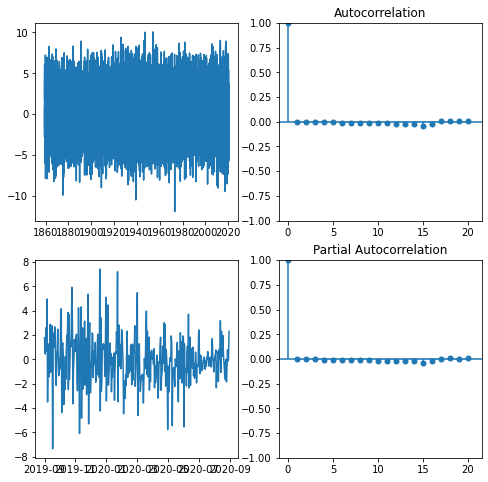

In [92]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].plot(res)
plot_acf(res,lags=20,ax = axs[0,1])
axs[1,0].plot(res[-365:])
plot_pacf(res,lags=20,ax = axs[1,1])
plt.show()